# Introduction

## Objective <br>

As of 2022, there are over 1000 entries in the Pokedex, varying in type combinations and stats. The objective of this mini project is to identify subgroups of Pokemon based on their stats, and to uncover insights of these clusters and their characteristics. Through this project, the different skills practiced include web scraping, data pre-processing, data exploration and visualization and clustering! <br>

## Method <br>

1. Import packages and write helper functions
2. Web-scraping and data exploration 
3. Clustering data and analysis of insights <br>

This mini project is for learning purposes and any feedback would be welcomed!


### 1. Import packages and write helper functions

In [1]:
import pandas as pd
import numpy as np
from math import pi

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import seaborn as sns

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

In [2]:
def type_split(typings, main = True):
    
    '''
    Helper function to return the main or secondary typing of a Pokemon
    eg "Grass Poison" is split into Main: "Grass", Secondary: "Poison"
    '''
    
    typings = typings.split(" ")
    main_type = typings[0]
    
    if len(typings) == 2:
        secondary_type = typings[1]
    else:
        secondary_type = ""
    
    if main:
        return main_type
    else:
        return secondary_type

In [3]:
def creating_main_df(data_dict):
    
    '''
    Helper function to generate the main dataframe with the data dictionary obtained from the web scraping
    Splits the types into main and secondary, and then generates unique rows for each (Pokemon, Type)
    
    eg Bulbasaur is a Grass and Poison type, hence there will be two rows for Bulbasaur, 
    one row with Type = "Grass", another with Type = "Poison"
    
    Identifies Mega and Regional variants of certain Pokemon with the fields "Mega" and "Variant"
    
    Generates binary fields for each Type (total 18 different Types)
    '''
    no = "#"
    name = "Name"
    Type = "Type"
    main_type = "Main Type"
    secondary_type = "Secondary Type"
    mega = "Mega"
    variant = "Variant"
    regions = ["Alolan", "Galarian", "Hisuian"]
    stats = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']
#    special_form = "Special Form"
    
    main_df = pd.DataFrame(data_dict)
    
    main_df[stats] = main_df[stats].astype(int)
    
    main_df[main_type] = main_df[Type].apply(lambda x: type_split(x))
    main_df[secondary_type] = main_df[Type].apply(lambda x: type_split(x, main = False))
    main_df = main_df.drop(labels = [Type], axis = 1)
    
    main_df_main_type = main_df.loc[:, main_df.columns != secondary_type]
    main_df_main_type = main_df_main_type.rename(columns = {"Main Type" : Type})
    
    main_df_secondary_type = main_df.loc[:, main_df.columns != main_type]
    main_df_secondary_type = main_df_secondary_type[main_df_secondary_type[secondary_type] != ""]
    main_df_secondary_type = main_df_secondary_type.rename(columns = {"Secondary Type" : Type})
    
    main_df = pd.concat([main_df_main_type, main_df_secondary_type])
    main_df = main_df.sort_index(ascending = True)
    main_df = main_df.reset_index(drop = True)
    
    main_df[mega] = main_df[name].apply(lambda x: mega in x)
    # mega_df = main_df[main_df[mega] == True]
    
    main_df[variant] = main_df[name].apply(lambda x: any(region in x for region in regions))
    # variant_df = main_df[main_df[variant] == True]
    
    # special_forms_df = main_df[main_df[no].duplicated(keep = False) & (main_df[no].isin(list(mega_df[no])) == False) \
    #                                                                 & (main_df[no].isin(list(variant_df[no])) == False)]
    # main_df = main_df[~main_df[name].isin(list(special_forms_df[name]))]
    
    types = sorted(list(main_df[Type].unique()))
    
    for typing in types:
        main_df[typing] = (main_df[Type] == typing)
        main_df[typing] = main_df[typing].apply(lambda x: int(x))
    
    return main_df


In [4]:
def creating_output_df(df, columns, excl_mega = True, excl_variant = False):
    
    '''
    Helper function to create the dataframe that will contain relevant columns to use, and which Pokemon to include in the analysis
    
    Default is to exclude Mega Pokemon for the analysis
    '''
    
    mega = "Mega"
    variant = "Variant"

    if excl_mega:
        df = df[df[mega] == False]
    
    if excl_variant:
        df = df[df[variant] == False]
        
    df = df[columns]
    
    return df

In [5]:
def stats_box_plot(df, stat):
    
    '''
    Helper function to generate a box plot for a specific stat eg Attack, Defense etc
    
    Box plot aggregated by type and is arranged in descending order of the median score
    '''
    
    color_pal = {'Bug': '#9ACD32', 'Dark': '#01153E', 'Dragon': '#00008B', 'Electric': '#FFFF00', 
                 'Fairy': '#FF81C0', 'Fighting': '#8C000F', 'Fire': '#E50000', 'Flying': '#7BC8F6', 
                 'Ghost': '#4B0082', 'Grass': '#008000', 'Ground': '#A0522D', 'Ice': '#40E0D0',
                 'Normal': '#F0FFFF', 'Poison': '#800080', 'Psychic': '#C20078', 'Rock': '#653700', 
                 'Steel': '#C0C0C0', 'Water': '#069AF3'}
    
    Type = "Type"

    # stat_df = df[[stat, Type]]
    # grouped_df = stat_df.groupby([Type]).median().sort_values(by = stat, ascending = False)
    # ordered_types = grouped_df.index.values
    # types_dtype = pd.CategoricalDtype(ordered_types, ordered=True)
    # stat_df[Type] = stat_df[Type].astype(types_dtype)
    # stats_boxplot = stat_df.boxplot(column = stat, by = Type, figsize = (15,9), return_type= 'both', patch_artist = True)    
    # plt.show()
    
    stat_df = df[[stat, Type]]
    ordered_types = stat_df.groupby(by = Type).median().sort_values(by = stat, ascending = False).index
    plt.figure(figsize=(12,8))
    sns.set(style="darkgrid")
    sns.boxplot(x = stat_df[Type], y = stat_df[stat], palette = color_pal, order = ordered_types)
    plt.ylabel(stat, size = 15)
    plt.title("Boxplot of {} by Type".format(stat), size = 20)
    plt.show()
    

In [2]:
def k_means_elbow(df, max_no_of_clusters, features):
    
    '''
    Helper function to plot a line graph, which is part of the elbow method to 
    determine the appropriate number of clusters to form.
    
    The x axis is the number of clusters, and the y-axis is the average "within cluster sum of squares score"
    '''

    X = df[features].values
    wcss = []
    
    for i in range(2, max_no_of_clusters + 1):
        kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(2, max_no_of_clusters + 1), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [9]:
def k_means_clustering(df, no_of_clusters, features):
    
    '''
    Helper function to perform k-means clustering based on the number of clusters and the features to use
    Assigns a cluster to each Pokemon by creating a new column in the main dataframe
    
    Creates a clusters_df which contains the cluster centroids for each cluster
    
    Returns both the main dataframe and the newly created clusters_df
    '''
    
    cluster = "Cluster"
    
    X = df[features].values
    kmeans = KMeans(n_clusters = no_of_clusters, init = "k-means++", random_state = 42)
    Y = kmeans.fit_predict(X)
    df[cluster] = Y+1
    
    clusters_df = pd.DataFrame(kmeans.cluster_centers_, columns = features)
    clusters_df = clusters_df.reset_index()
    clusters_df["index"] = clusters_df["index"] + 1
    clusters_df = clusters_df.rename(columns = {"index": "Cluster"})
        
    return df, clusters_df

In [ ]:
def k_means_radar(cluster_df):
    
    '''
    Helper function to plot radar charts for each cluster using their respective centroids
    '''
    
    stats = list(cluster_df)[1:]
    angles = [n / float(len(stats)) * 2 * pi for n in range(len(stats))]
    angles += angles[:1]

    fig, ax = plt.subplots(nrows=1, ncols=len(cluster_df), figsize=(35, 10), subplot_kw=dict(polar=True), sharey = True, sharex = True)
    j = 0
    
    for cluster in range(len(cluster_df)):

        val_c = cluster_df.iloc[cluster].drop('Cluster').values.flatten().tolist()
        val_c += val_c[:1]
        ax[j].plot(angles, val_c, linewidth=1, linestyle='solid', label='Cluster {}'.format(cluster + 1))
        ax[j].fill(angles, val_c, 'skyblue', alpha=0.1)
        ax[j].set_xticks(angles[:-1])
        ax[j].set_xticklabels(stats)
        ax[j].legend(loc='upper center')
        j += 1
        
    plt.show()

### 2. Web-scraping and data exploration <br>

To get the data into a dataframe format for exploration analysis, the raw data is scraped from https://pokemondb.net/pokedex/all using BeautifulSoup and transformed into the main dataframe by using the helper function "creating_main_df" which was defined earlier

In [10]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}
req = Request(url="https://pokemondb.net/pokedex/all", headers=headers) 
html = urlopen(req).read() 
soup = BeautifulSoup(html, 'lxml')


col_labels = soup.find_all('th')
headers = []
col_str = str(col_labels)
headers = BeautifulSoup(col_str, "lxml").get_text()
headers = headers.strip('[')
headers = headers.strip(']')
headers = headers.split(', ')
data_dict_temp = {}
for n in range(len(headers)):
    data_dict_temp[n] = []
    
    
rows = soup.find_all('tr')
list_rows = []
for row in rows:
    row_td = row.find_all('td')
    str_cells = str(row_td)
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    list_rows.append(cleantext)
list_rows = list_rows[1:]    


for row in list_rows:
    row = row.strip('[')
    row = row.strip(']')
    row = row.split(', ')
    for n in range(len(row)):
        data_dict_temp[n].append(row[n])
data_dict = {}
for n in range(len(headers)):
    data_dict[headers[n]] = data_dict_temp[n]


main_df = creating_main_df(data_dict)

In [11]:
list(main_df.columns)
types = sorted(list(main_df['Type'].unique()))
stats = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']
stats_no_total = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']
output_headers = ["#", 'Name','Type','Mega',"Variant"] + stats + types
output_df = creating_output_df(main_df, output_headers)
output_df.head(15)

,#,Name,Type,Mega,Variant,Total,HP,Attack,Defense,Sp. Atk,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,001,Bulbasaur,Grass,False,False,318,45,49,49,65,...,0,1,0,0,0,0,0,0,0,0
1,001,Bulbasaur,Poison,False,False,318,45,49,49,65,...,0,0,0,0,0,1,0,0,0,0
2,002,Ivysaur,Grass,False,False,405,60,62,63,80,...,0,1,0,0,0,0,0,0,0,0
3,002,Ivysaur,Poison,False,False,405,60,62,63,80,...,0,0,0,0,0,1,0,0,0,0
4,003,Venusaur,Grass,False,False,525,80,82,83,100,...,0,1,0,0,0,0,0,0,0,0
5,003,Venusaur,Poison,False,False,525,80,82,83,100,...,0,0,0,0,0,1,0,0,0,0
8,004,Charmander,Fire,False,False,309,39,52,43,60,...,0,0,0,0,0,0,0,0,0,0
9,005,Charmeleon,Fire,False,False,405,58,64,58,80,...,0,0,0,0,0,0,0,0,0,0
10,006,Charizard,Fire,False,False,534,78,84,78,109,...,0,0,0,0,0,0,0,0,0,0
11,006,Charizard,Flying,False,False,534,78,84,78,109,...,0,0,0,0,0,0,0,0,0,0



Each row contains a unique "Name/Type" combination. Pokemon with dual typings will have two rows. <br>
A binary column for each typing is also present for each row.

In [12]:
color_pal = {'Bug': '#9ACD32', 'Dark': '#01153E', 'Dragon': '#00008B', 'Electric': '#FFFF00', 
             'Fairy': '#FF81C0', 'Fighting': '#8C000F', 'Fire': '#E50000', 'Flying': '#7BC8F6', 
             'Ghost': '#4B0082', 'Grass': '#008000', 'Ground': '#A0522D', 'Ice': '#40E0D0',
             'Normal': '#F0FFFF', 'Poison': '#800080', 'Psychic': '#C20078', 'Rock': '#653700', 
             'Steel': '#C0C0C0', 'Water': '#069AF3'}

Initial exploration questions to answer: <br>
- What is the most/least common type among all Pokemon?
- What is the most common dual typing among all Pokemon?
- What is the spread of stats for each typing like?
- Which typing is the strongest for each stat?


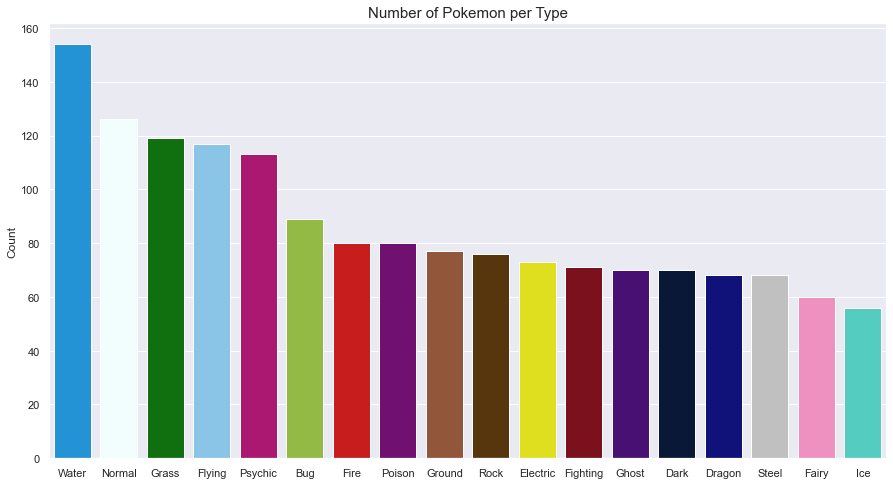

In [13]:
count_df = pd.DataFrame(columns = ["Count"], data = output_df[types].sum(axis = 0)).sort_values(by = "Count", ascending = False)

plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
sns.barplot(x = count_df.index.values, y = count_df["Count"], palette = color_pal)
plt.title("Number of Pokemon per Type", size = 15)
plt.show()

In [14]:
round((len(set(output_df[output_df["Type"] == "Water"]["Name"]))/len(set(output_df["Name"])) * 100),0)

15.0

The top 3 most common types are Water, Normal and Grass, with Water having about 150 unique Pokemon, and comprising of 15% of all Pokemon! <br>
Ice is the least common type with just under 60 unique Pokemon

In [15]:
dual_types_df_1 = output_df[["Name", "Type"]]
dual_types_df_1 = dual_types_df_1.rename(columns = {"Type": "Type 1"})

dual_types_df_2 = output_df[["Name", "Type"]]
dual_types_df_2 = dual_types_df_2.rename(columns = {"Type": "Type 2"})

dual_types_df = pd.merge(dual_types_df_1, dual_types_df_2, how = "left", on = "Name")
dual_types_df = dual_types_df[dual_types_df["Type 1"] != dual_types_df["Type 2"]]
dual_types_df = dual_types_df.drop_duplicates(subset = ["Name"], keep = "first")
dual_types_df["Type"] = dual_types_df["Type 1"] + "/" + dual_types_df["Type 2"]
dual_types_df = dual_types_df[["Name","Type"]]

dual_types = []
for type1 in types:
    for type2 in types:
        if type1 == type2:
            pass
        else:
            if (type1 + "/" + type2 in dual_types) or (type2 + "/" + type1 in dual_types):
                pass
            else:
                dual_types_df[type1 + "/" + type2] = dual_types_df["Type"].apply(lambda x: 1 if (x == type1 + "/" + type2 or x == type2 + "/" + type1) else 0)
                dual_types.append(type1 + "/" + type2)
            
dual_types_count_df = pd.DataFrame(columns = ["Count"], data = dual_types_df[[cols for cols in dual_types]].transpose().sum(axis = 1)).sort_values(by = "Count", ascending = False)
dual_types_exist_count_df = dual_types_count_df[dual_types_count_df["Count"] != 0]
dual_types_nonexist_count_df = dual_types_count_df[dual_types_count_df["Count"] == 0]

C:\Users\angus\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


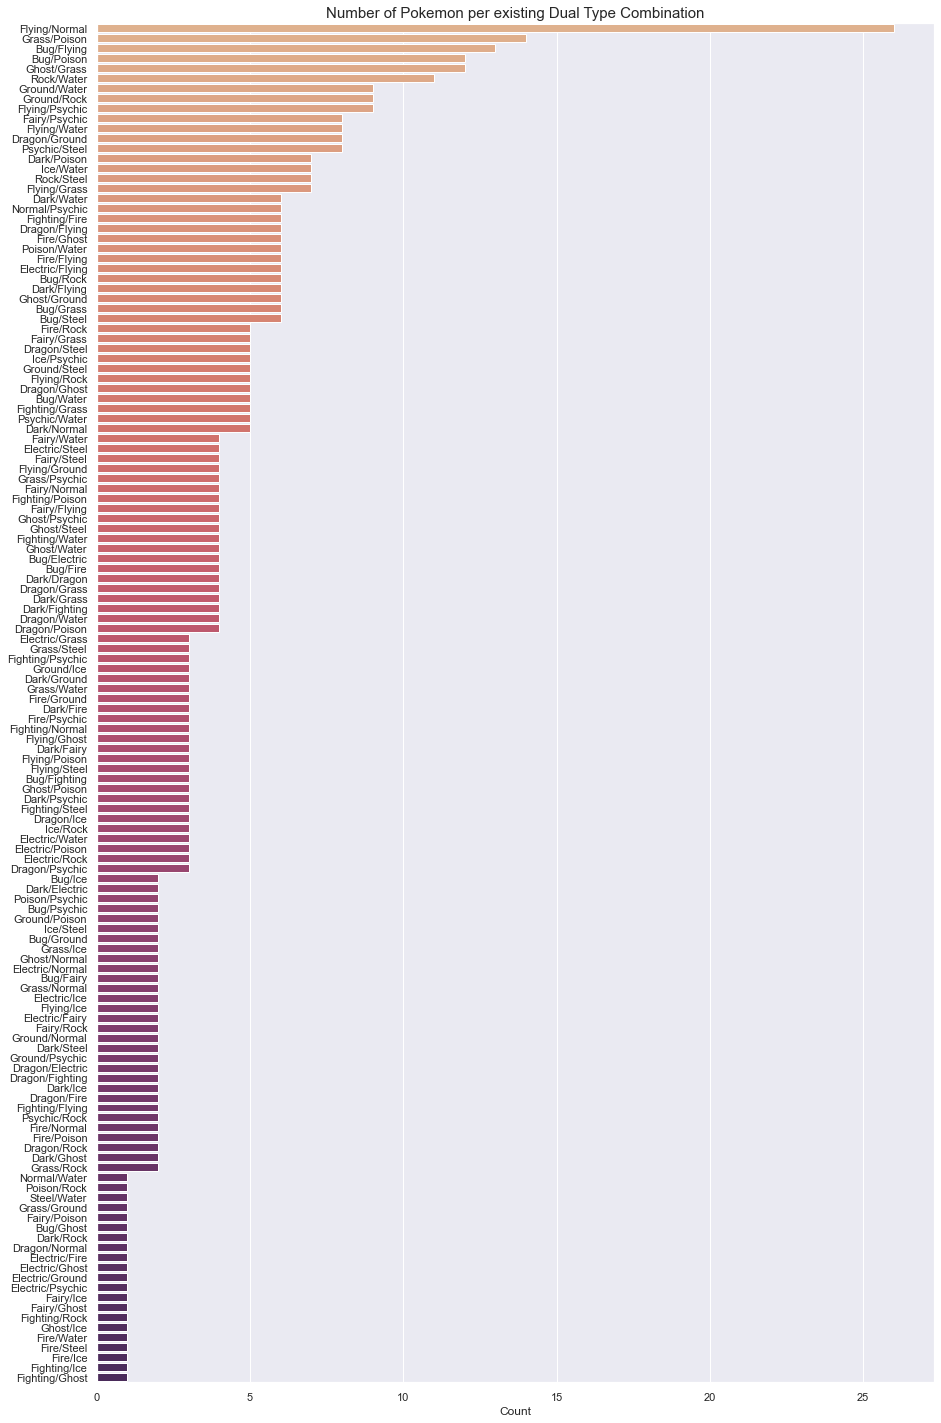

In [16]:
plt.figure(figsize=(15,25))
sns.set(style="darkgrid")
sns.barplot(y = dual_types_exist_count_df.index.values, x = dual_types_exist_count_df["Count"], orient = 'h', palette = "flare")
plt.title("Number of Pokemon per existing Dual Type Combination", size = 15)
plt.show()

In [17]:
dual_types_nonexist_count_df.index.values

array(['Bug/Dragon', 'Bug/Normal', 'Dragon/Fairy', 'Electric/Fighting',
       'Poison/Steel', 'Fire/Grass', 'Normal/Steel', 'Normal/Rock',
       'Normal/Poison', 'Fairy/Fighting', 'Fairy/Fire', 'Ghost/Rock',
       'Fairy/Ground', 'Ice/Poison', 'Ice/Normal', 'Fighting/Ground',
       'Bug/Dark'], dtype=object)

The most common dual typing by far is the Flying/Normal dual type, with more than 25 unique Pokemon! <br>
There are 17 unused dual typings so far

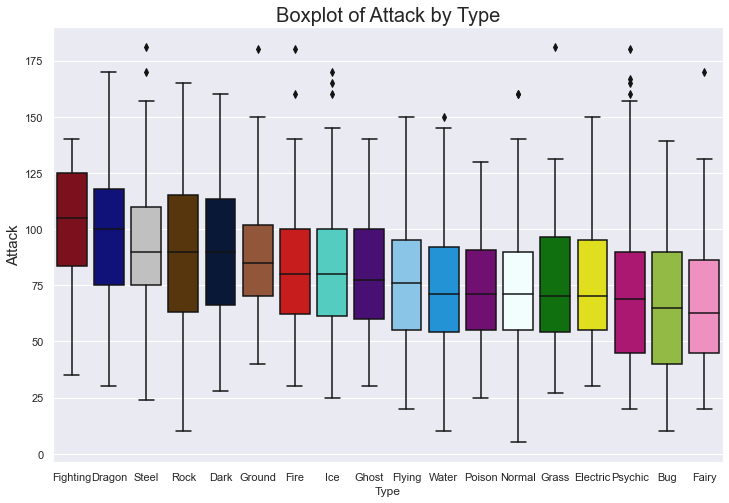

In [18]:
stats_box_plot(output_df, "Attack")

In [19]:
attack_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Attack"].sort_values(ascending = False).head(5))
attack_top_5

,Attack
Type,
Fighting,105.0
Dragon,100.0
Steel,90.0
Rock,90.0
Dark,90.0


For the Attack stat, Fighting types have the highest median score (105). Fighting types are known for their strong Attack stats!

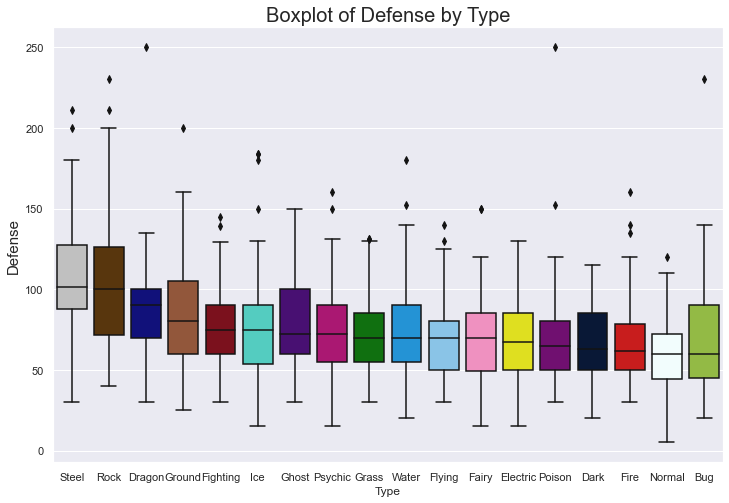

In [20]:
stats_box_plot(output_df, "Defense")

In [21]:
defense_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Defense"].sort_values(ascending = False).head(5))
defense_top_5

,Defense
Type,
Steel,101.5
Rock,100.0
Dragon,90.0
Ground,80.0
Fighting,75.0


For the Defense stat, Steel and Rock types have the top two highest median score (101.5 and 100 respectively). This confirms that Steel and Rock types generally have very high Defense stats!

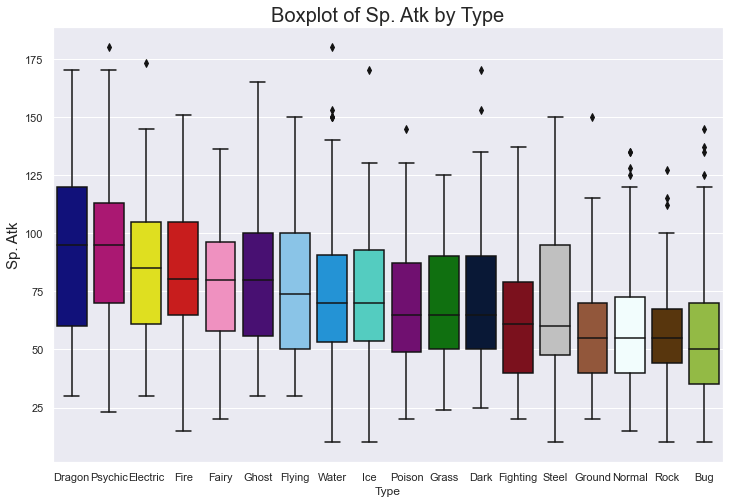

In [22]:
stats_box_plot(output_df, "Sp. Atk")

In [23]:
spattack_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Sp. Atk"].sort_values(ascending = False).head(5))
spattack_top_5

,Sp. Atk
Type,
Dragon,95.0
Psychic,95.0
Electric,85.0
Fire,80.5
Fairy,80.0


For the Sp Atk stat, Dragon and Psychic types have the joint highest median score (95). 

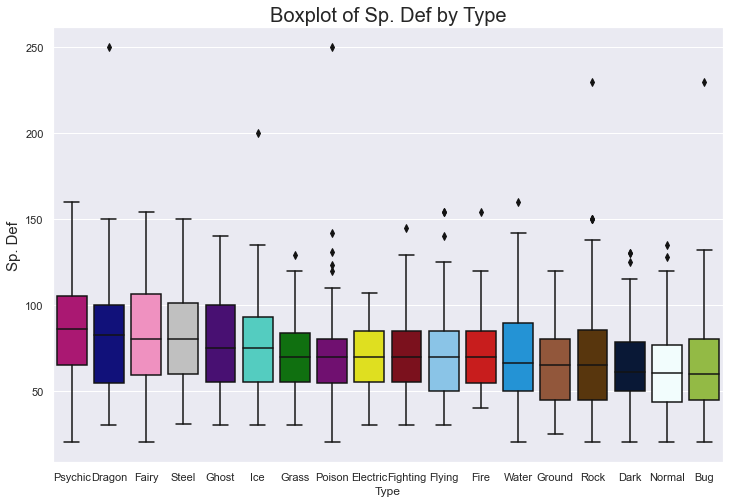

In [24]:
stats_box_plot(output_df, "Sp. Def")

In [25]:
spdefense_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Sp. Def"].sort_values(ascending = False).head(5))
spdefense_top_5

,Sp. Def
Type,
Psychic,86.0
Dragon,82.5
Fairy,80.0
Steel,80.0
Ghost,75.0


For the Sp Def stat, Psychic types have the highest median score (86). Psychic types generally have very high Sp Atk and Sp Def stats

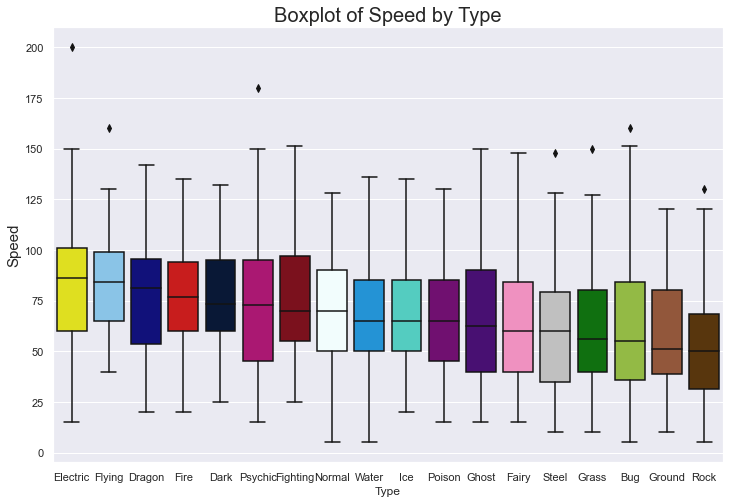

In [26]:
stats_box_plot(output_df, "Speed")

In [27]:
speed_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Speed"].sort_values(ascending = False).head(5))
speed_top_5

,Speed
Type,
Electric,86.0
Flying,84.0
Dragon,81.0
Fire,77.0
Dark,73.5


For the Speed stat, Electric types have the highest median score (86). Electric types are known to be fast Pokemon that hit quickly!

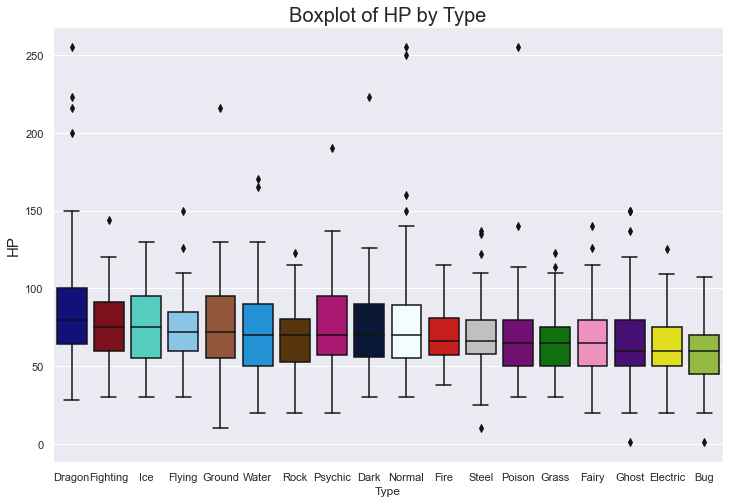

In [28]:
stats_box_plot(output_df, "HP")

In [29]:
hp_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["HP"].sort_values(ascending = False).head(5))
hp_top_5

,HP
Type,
Dragon,80.0
Fighting,75.0
Ice,75.0
Flying,72.0
Ground,72.0


For the HP stat, Dragon types have the highest median score (80). Most Dragon Pokemon are Legendaries, which explains the typing having the highest HP median score

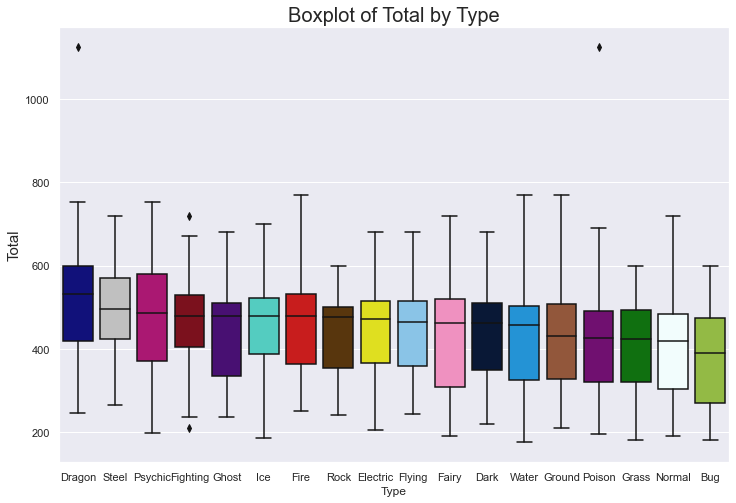

In [30]:
stats_box_plot(output_df, "Total")

In [31]:
total_top_5 = pd.DataFrame(output_df.groupby(["Type"]).median()["Total"].sort_values(ascending = False).head(5))
total_top_5

,Total
Type,
Dragon,532.5
Steel,495.0
Psychic,485.0
Fighting,480.0
Ghost,480.0


For the Total stat, Dragon types have the highest median score (532.5). Again,this is likely due to most Dragon Pokemon are Legendaries, which explains the typing dominance. Next highest median score belongs to the Steel type (495)

In [32]:
type_top_5_count = {}
for Type in types:
    top_5_count = 0
    for top_5 in [attack_top_5, defense_top_5, spattack_top_5, spdefense_top_5, speed_top_5, hp_top_5]: 
        if Type in top_5.index:
            top_5_count += 1
    type_top_5_count[Type] = top_5_count
    
type_top_5_count_df = pd.DataFrame(type_top_5_count.items(), columns=['Type', 'Count'])
type_top_5_count_df = type_top_5_count_df.set_index("Type")
type_top_5_count_df = type_top_5_count_df.sort_values(by = ["Count"], ascending = False)
type_top_5_count_df


,Count
Type,
Dragon,6
Fighting,3
Steel,3
Psychic,2
Electric,2
Fairy,2
Fire,2
Flying,2
Dark,2


Overall, Dragon type appears in all of the top 5 stats ranking, confirming it the strongest type. <br>
Steel and Fighting types appear in 3 of the top 5 as well!

### 3. Clustering data and analysis of insights

The features that will be used for clustering are the stats features excluding the "Total" stat. The features used are Attack, Defense, Sp. Atk, Sp. Def, Speed and HP. <br>

To determine the appropriate number of clusters to form, the elbow method will be used. The elbow method plots a line graph of the average "within cluster sum of squares score" (WCSS) as a function of the number of clusters. <br>

As the number of clusters increase, the average WCSS will decrease, as there are more clusters and the euclidean distance between each instance and their respective cluster decreases. <br> 

The elbow method helps to visually identify the number of clusters where the decrease in average WCSS is the greatest, as denoted by the "elbow" on the line graph

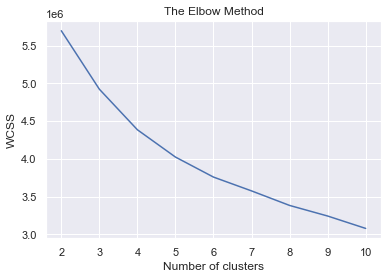

In [128]:
k_means_features = stats_no_total
k_means_elbow(output_df, 10, k_means_features)

Setting the number of clusters to be equal to 5, the k-means clustering algorithm is ran on the Pokemon dataset <br>

The clusters are then analysed for their specific characteristics based on stats and typing

In [49]:
no_of_clusters = 5
output_df, clusters_df = k_means_clustering(output_df, no_of_clusters, k_means_features)

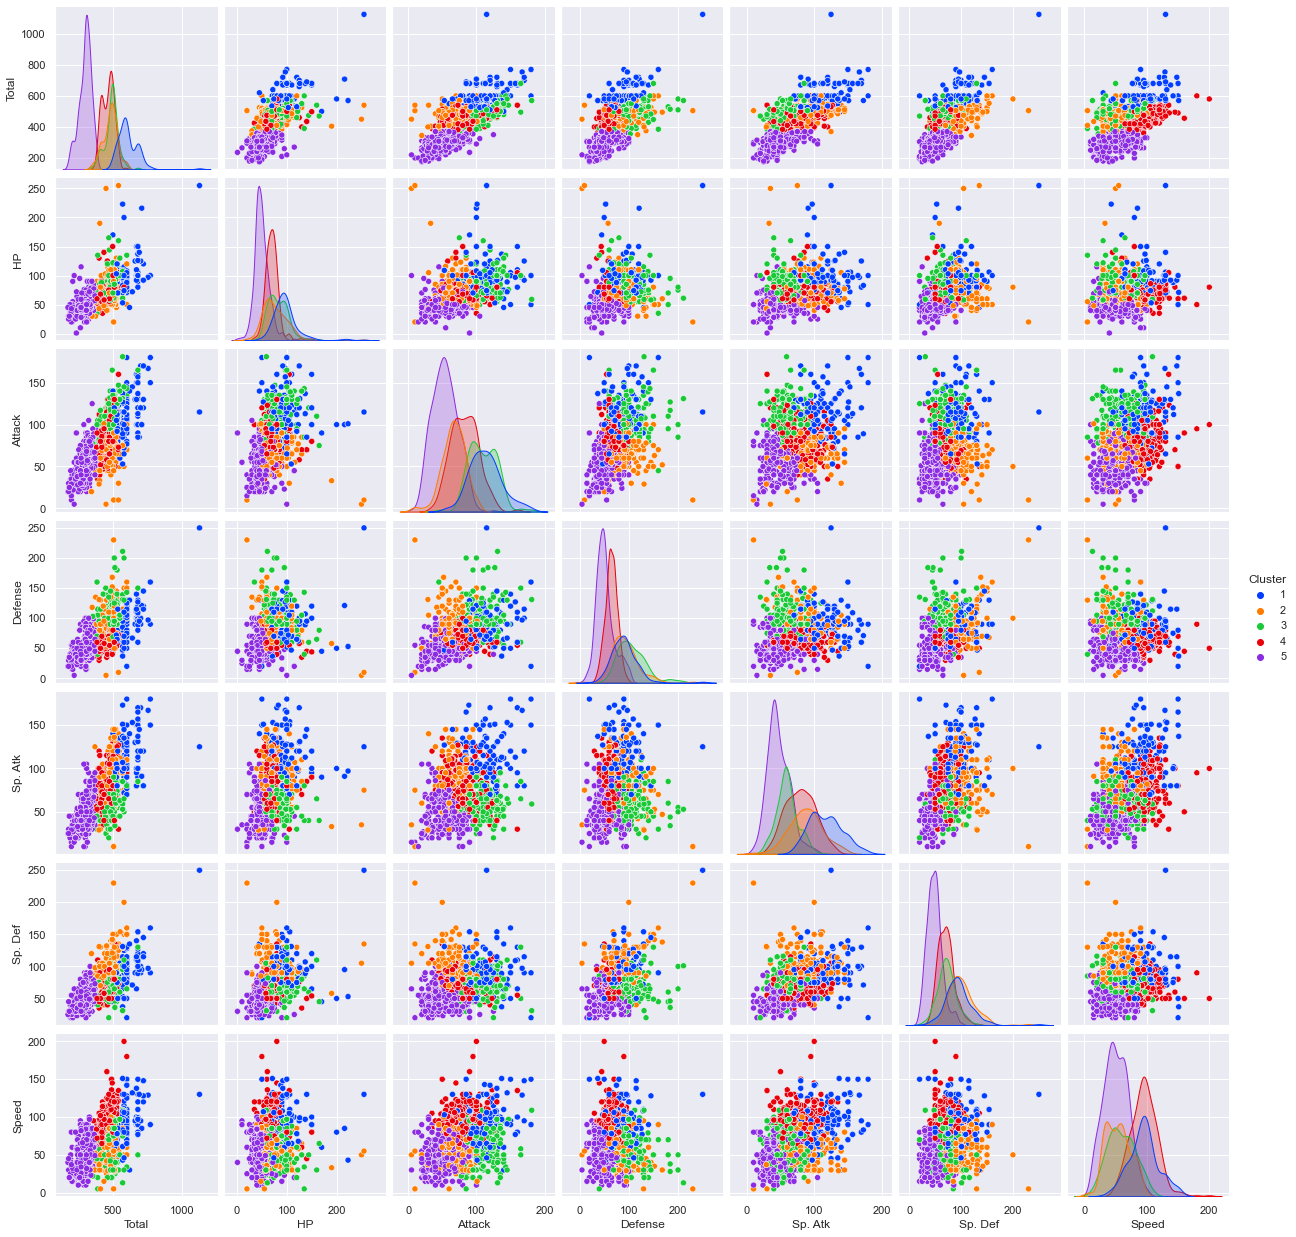

In [50]:
sns.pairplot(output_df[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', "Cluster"]], hue = "Cluster", palette = "bright")

Based on the pair plot, we can form some initial obvious insights: <br>

- Cluster 5 is the largest cluster and the Pokemon in there are considered weak, with low stats
- Cluster 1 seems to contain alot of strong Pokemon, with high stats overall


In [132]:
clusters_df

,Cluster,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,98.221277,113.174468,89.940426,116.902128,94.808511,94.889362
1,2,76.866397,66.465587,92.477733,87.449393,101.874494,53.336032
2,3,81.694779,109.489960,106.357430,59.329317,71.851406,59.196787
3,4,70.270655,82.652422,64.159544,79.470085,70.364672,95.222222
4,5,49.012371,53.703093,51.127835,46.802062,48.171134,49.870103


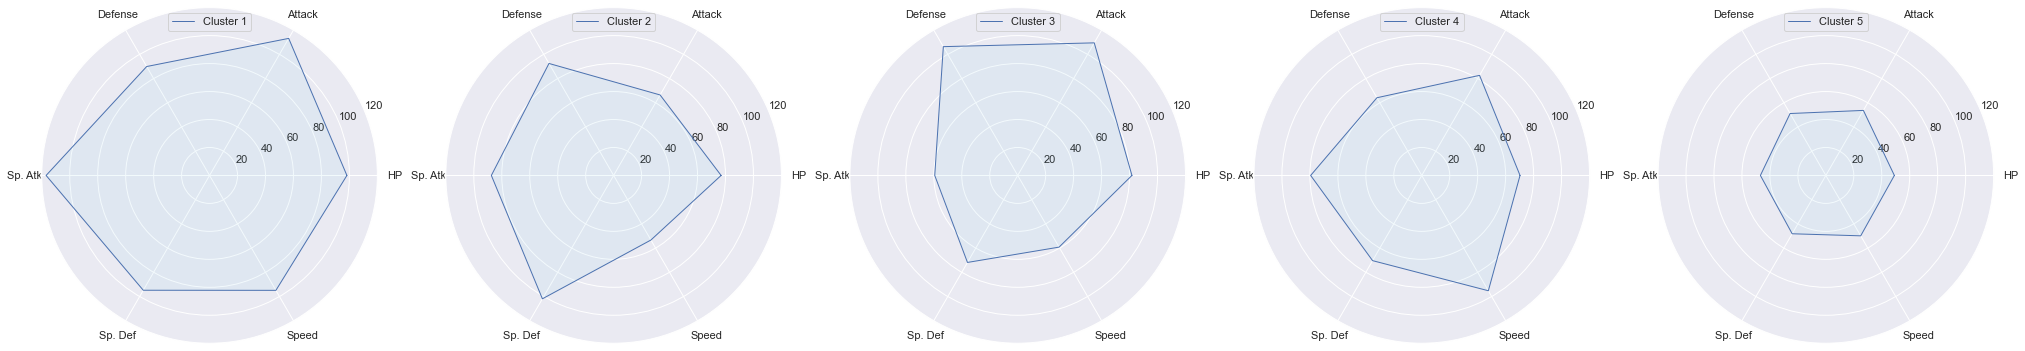

In [129]:
k_means_radar(clusters_df)

Based on individual radar plots for each cluster's centroids, we draw further insights on the general characteristics of each Pokemon in each cluster: <br>

- Cluster 1 dominates in all stats, containing very strong Pokemon
- Cluster 2 contains Pokemon with high Sp. Atk and Sp. Def stats, but have very low Speed
- Cluster 3 contains Pokemon with high Attack and Defense stats, but also very low Speed
- Cluster 4 contains Pokemon with high Speed, but very low Defense
- Cluster 5 is the lowest in all stats, containing very weak Pokemon


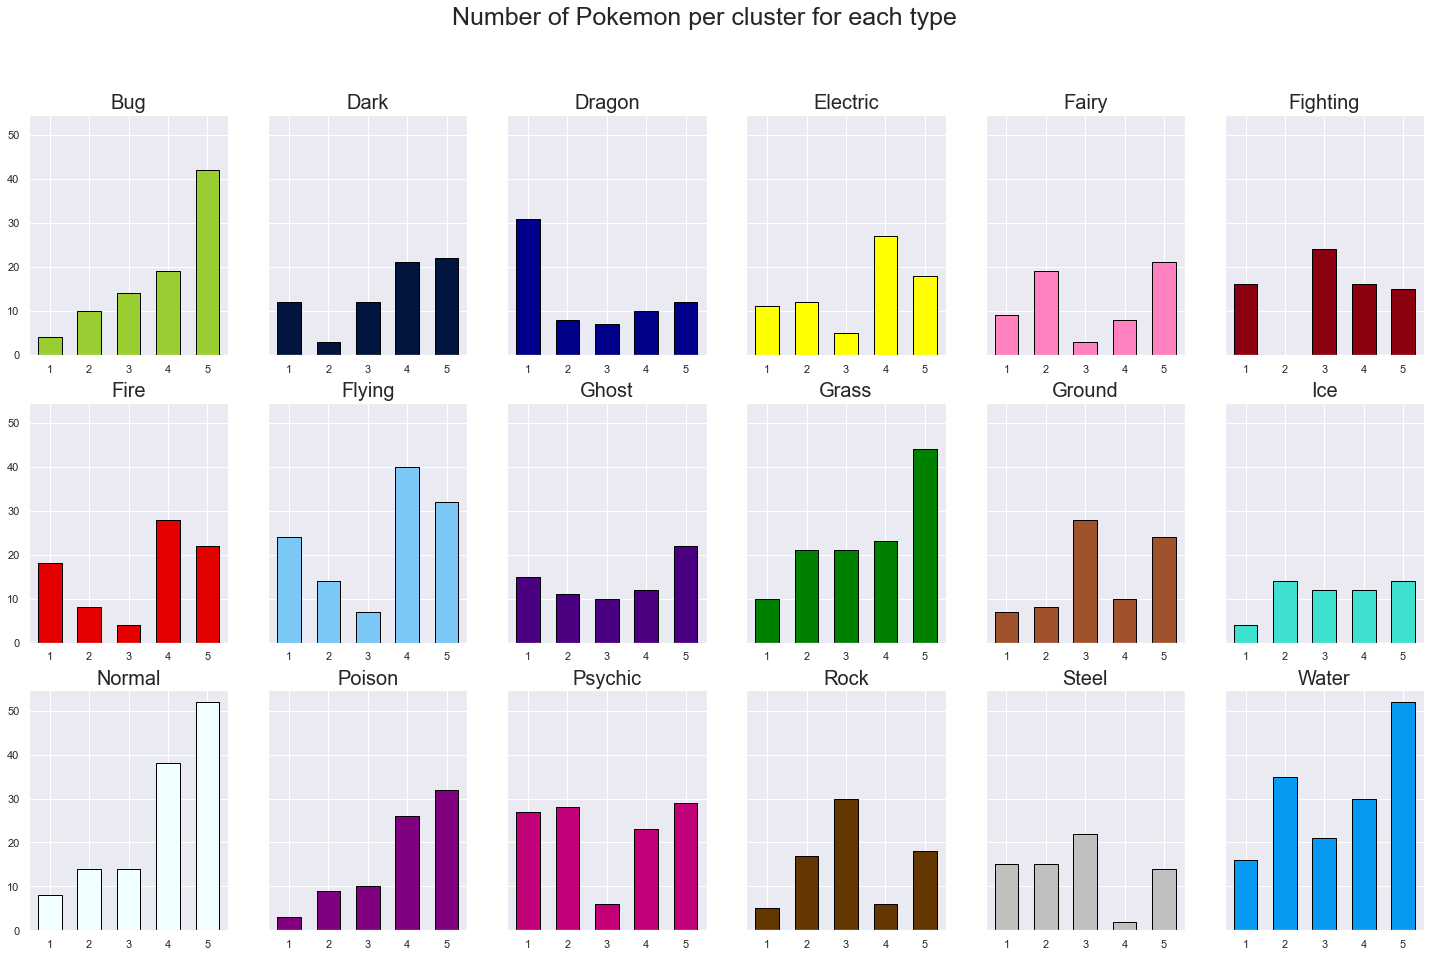

In [52]:
colors = ['#9ACD32', '#01153E', '#00008B', '#FFFF00', '#FF81C0', '#8C000F',
          '#E50000', '#7BC8F6', '#4B0082', '#008000', '#A0522D', '#40E0D0',
          '#F0FFFF', '#800080', '#C20078', '#653700', '#C0C0C0', '#069AF3']

fig, ax = plt.subplots(3,6, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(25)
width = 0.6
i,j = 0,0

for typing in types:
    df_type = output_df[output_df["Type"] == typing]
    df_type_cluster_group = pd.DataFrame(df_type.groupby(["Cluster"]).count()["#"])
    ax[i,j].bar(df_type_cluster_group.index.values, 
                df_type_cluster_group["#"], color = colors[types.index(typing)],
                width = width, edgecolor = 'black', label=typing)
    ax[i,j].set_title(typing, fontsize=20)
    j += 1
    if j >= 6:
        i += 1
        j = 0

fig.suptitle("Number of Pokemon per cluster for each type", fontsize=25)
plt.show()

From a Type perspective, we can draw the following insights: <br>
- Majority of Dragon Pokemon are in Cluster 1. Dragons are generally powerful Pokemon with high stats
- Majority of Fighting, Rock and Steel Pokemon are in Cluster 3. Fighting Pokemon have generally high Attack stats and Rock and Steel Pokemon have generally high Defense stats 
- Majority of Flying and Electric Pokemon are in Cluster 4. Pokemon in both types are generally very speedy but also very weak defensively
- Majority of Bug, Grass, Normal and Water Pokemon are in Cluster 5. These types generally have alot of early stage and hence weaker Pokemon

In [53]:
output_df["Cluster"].value_counts()

5    485
4    351
3    250
2    246
1    235
Name: Cluster, dtype: int64

In [54]:
cluster_dict = {}
for i in range(no_of_clusters):

    cluster = output_df[output_df["Cluster"] == i + 1]
    cluster = cluster[["Name"] + stats_no_total + types]
    cluster["Distance to cluster mean"] = np.sqrt(
    (cluster["HP"] - clusters_df["HP"].loc[i])**2 +
    (cluster["Attack"] - clusters_df["Attack"].loc[i])**2 + 
    (cluster["Defense"] - clusters_df["Defense"].loc[i])**2 + 
    (cluster["Sp. Atk"] - clusters_df["Sp. Atk"].loc[i])**2 + 
    (cluster["Sp. Def"] - clusters_df["Sp. Def"].loc[i])**2 + 
    (cluster["Speed"] - clusters_df["Speed"].loc[i])**2)
    cluster = cluster.sort_values(by = "Distance to cluster mean", ascending = True)

    cluster = cluster[["Name", "Distance to cluster mean"] + stats_no_total]
    cluster = cluster.drop_duplicates(subset = ["Name"])
    cluster_no = "Cluster {}".format(i + 1)
    cluster_dict[cluster_no] = cluster

In [57]:
cluster_dict['Cluster 1'].head(10)

,Name,Distance to cluster mean,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
1144,Hydreigon,14.279466,92,105,90,125,90,98
293,Moltres,20.660296,90,100,90,125,85,90
1166,Landorus Incarnate Forme,22.025637,89,125,90,115,80,101
1471,Necrozma,23.454368,97,107,101,127,89,79
474,Celebi,24.832994,100,100,100,100,100,100
718,Jirachi,24.832994,100,100,100,100,100,100
304,Mew,24.832994,100,100,100,100,100,100
914,Shaymin Land Forme,24.832994,100,100,100,100,100,100
918,Victini,24.832994,100,100,100,100,100,100
912,Manaphy,24.832994,100,100,100,100,100,100


Cluster 1 contains mostly legendary Pokemon and Dragon Types! Pokemon in this cluster have very high stats and are very powerful (eg. Hydreigon, Moltres, Necrozma)

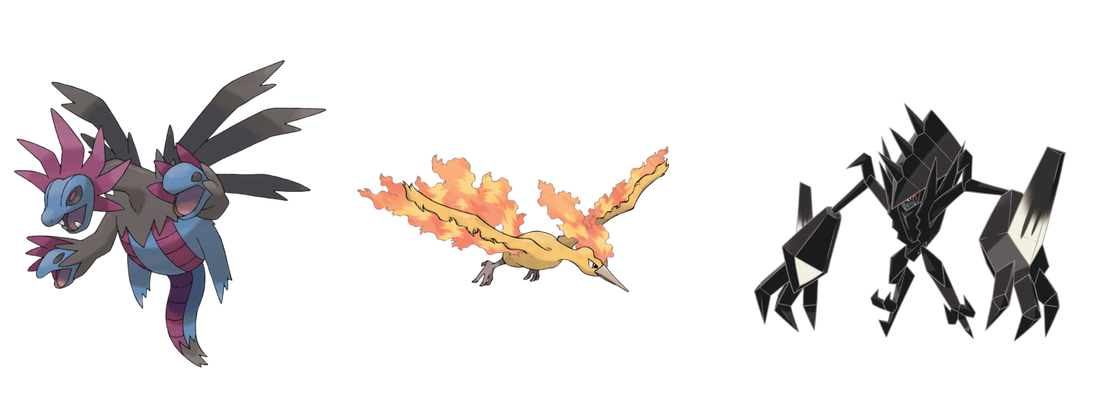

In [58]:
cluster_dict['Cluster 2'].head(10)

,Name,Distance to cluster mean,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
352,Bellossom,14.634686,75,80,95,90,100,50
1051,Gothitelle,21.072555,70,55,95,95,110,65
1408,Oranguru,22.066424,90,60,80,90,110,60
645,Cradily,22.131918,86,81,97,81,107,43
775,Vespiquen,23.544857,70,80,102,80,102,40
447,Porygon2,25.596210,85,80,90,105,95,60
665,Chimecho,27.646993,75,50,80,95,90,65
764,Wormadam Plant Cloak,27.889530,60,59,85,79,105,36
513,Ludicolo,28.552884,80,70,70,90,100,70
358,Politoed,28.956968,90,75,75,90,100,70


Cluster 2 contains Pokemon with strong special stats!  (eg Gothitelle, Porygon2, Bellossom)

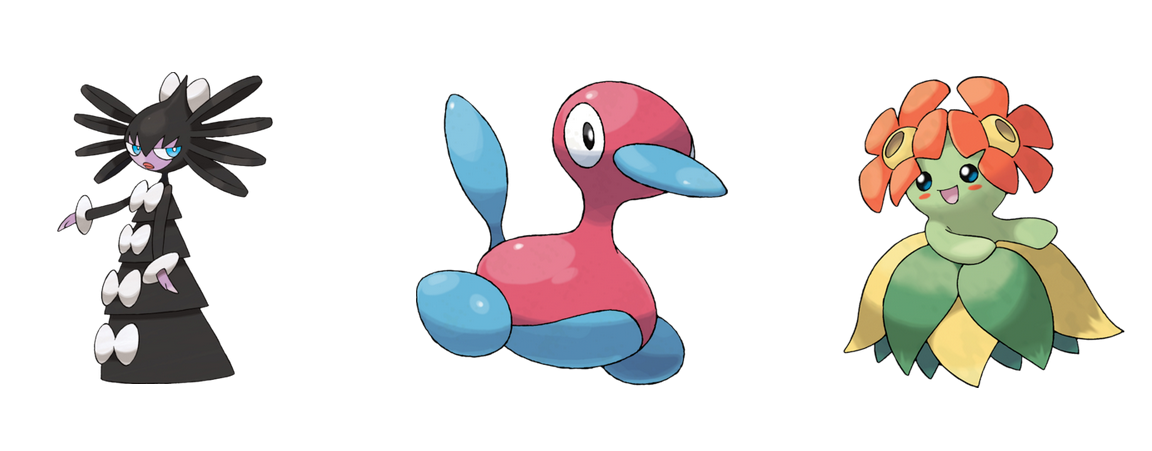

In [59]:
cluster_dict['Cluster 3'].head(10)

,Name,Distance to cluster mean,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
1301,Gourgeist Super Size,19.605131,85,100,122,58,75,54
1566,Perrserker,22.125049,70,110,100,50,60,50
1246,Barbaracle,22.246874,72,105,115,54,86,68
1187,Chesnaught,23.213340,88,107,122,74,75,64
446,Donphan,24.311394,90,120,120,60,60,50
1299,Gourgeist Large Size,24.642498,75,95,122,58,75,69
726,Torterra,24.653334,95,109,105,75,85,56
1535,Sandaconda,24.952640,72,107,125,65,70,71
60,Sandslash,25.906065,75,100,110,45,55,65
1124,Bisharp,26.082194,65,125,100,60,70,70


Cluster 3 contains Pokemon that are slow but bulky and hit hard! (eg Perrserker, Barbaracle, Donphan)

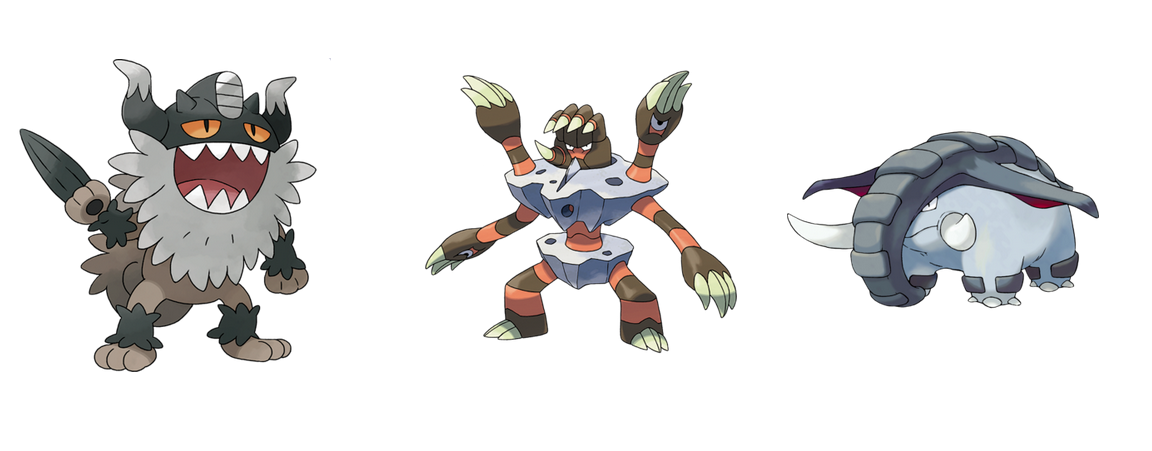

In [60]:
cluster_dict['Cluster 4'].head(10)

,Name,Distance to cluster mean,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
1057,Swanna,12.699084,75,87,63,87,63,98
385,Girafarig,15.873487,70,80,65,90,65,85
879,Froslass,16.125013,70,80,70,80,70,110
85,Golbat,17.934721,75,80,70,65,75,90
448,Stantler,18.122614,73,95,62,85,65,85
1001,Basculin White-Striped Form,18.227091,70,92,65,80,55,98
1000,Basculin Blue-Striped Form,18.227091,70,92,65,80,55,98
999,Basculin Red-Striped Form,18.227091,70,92,65,80,55,98
345,Xatu,19.021328,65,75,70,95,70,95
36,Pidgeot,20.243153,83,80,75,70,70,101


Cluster 4 contains Pokemon that are fast but defensively weak! (eg Swanna, Golbat, Froslass)

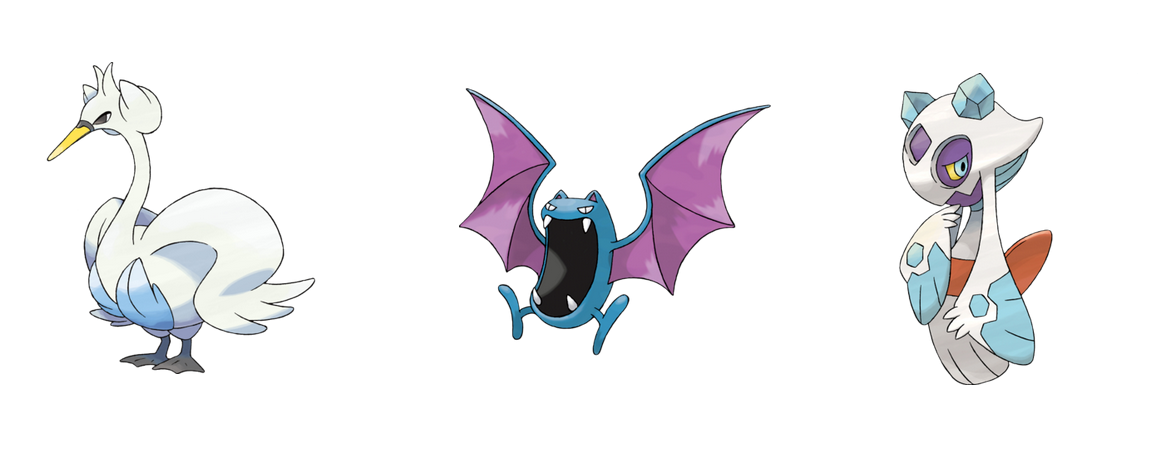

In [61]:
cluster_dict['Cluster 5'].head(10)

,Name,Distance to cluster mean,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
669,Snorunt,5.435876,50,50,50,50,50,50
264,Ditto,6.949471,48,48,48,48,48,48
1240,Inkay,12.000270,53,54,53,37,46,45
1380,Mareanie,13.134212,50,53,62,43,52,45
461,Larvitar,13.912032,50,64,50,45,50,41
1353,Grubbin,14.236525,47,62,45,55,45,46
1546,Sizzlipede,14.263076,50,65,45,50,50,45
296,Dratini,14.878279,41,64,45,50,50,50
97,Venonat,15.501656,60,55,50,40,55,45
1439,Jangmo-o,15.723850,45,55,65,45,45,45


Cluster 5 contains Pokemon that are generally weak and commonly first stage Pokemon! (eg Snorunt, Ditto, Inkay)

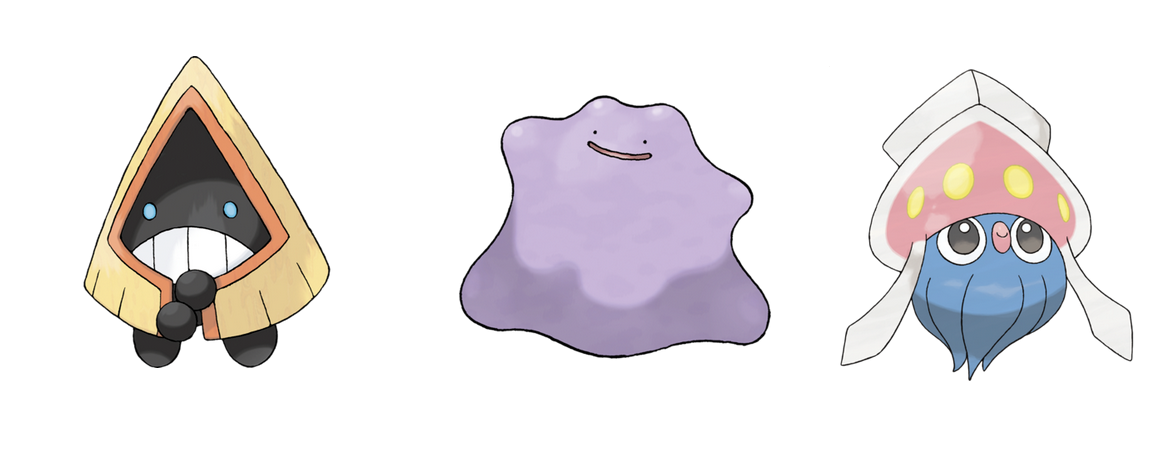

### Conclusion and final thoughts <br>

Through data pre-processing and k-means clustering, Pokemon can be grouped into specific clusters based on their stats and typings. <br>
However, there are more characteristics about Pokemon that can change or further improve the clustering, such as the stage evolution a Pokemon is at, legendaries, or even their moveset. <br>
Through this mini-project by using Pokemon as a fun example, we can see clustering is a powerful tool to classify a population into subgroups based on their characteristics. It is a form of unsupervised learning that can be applied to many different situations that require segmentation of a population!

Any feedback is greatly welcomed!
